In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as an
import scipy
from scipy.sparse import csr_matrix
import sklearn
import gget
import scanpy.external as sce
import math
from sklearn.metrics.pairwise import cosine_similarity

sc.settings.verbosity = 3  

import utils as ut
import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/merged_scfib.h5ad"
adata = sc.read_h5ad(fpath)
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]
sc.logging.print_memory_usage()
adata

Memory usage: current 8.13 GB, difference +8.13 GB


AnnData object with n_obs × n_vars = 16130 × 13579
    obs: 'cluster_str', 'dataset', 'pred_phase', 'leiden', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'new_cluster', 'UMAP 1', 'UMAP 2'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cluster_str_colors', 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'pca', 'pred_phase_colors', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    layers: 'combat', 'counts', 'log_norm', 'magic', 'norm'
    obsp: 'connectivities', 'distances'

In [3]:
# make the cluster variable
adata.obs['new_cluster_str'] = adata.obs['new_cluster'].apply(lambda x: f"F{int(x) + 1}")

# make a group variable
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C2', 'C5']), 'HSC-like', 'BJ Fib')
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C1', 'C3']), 'HSC-null', adata.obs['group'])
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C4']), 'Spike', adata.obs['group'])
adata.obs['group'].value_counts()

group
BJ Fib      7807
HSC-null    5525
HSC-like    2196
Spike        602
Name: count, dtype: int64

In [4]:
# Filter
adata = adata[~adata.obs['new_cluster_str'].isin(['F8', 'F9']), :].copy()
adata.obs['new_cluster_str'].value_counts()

new_cluster_str
F1    4324
F2    3790
F3    3508
F4    1461
F5    1249
F6     582
F7     561
Name: count, dtype: int64

... storing 'group' as categorical


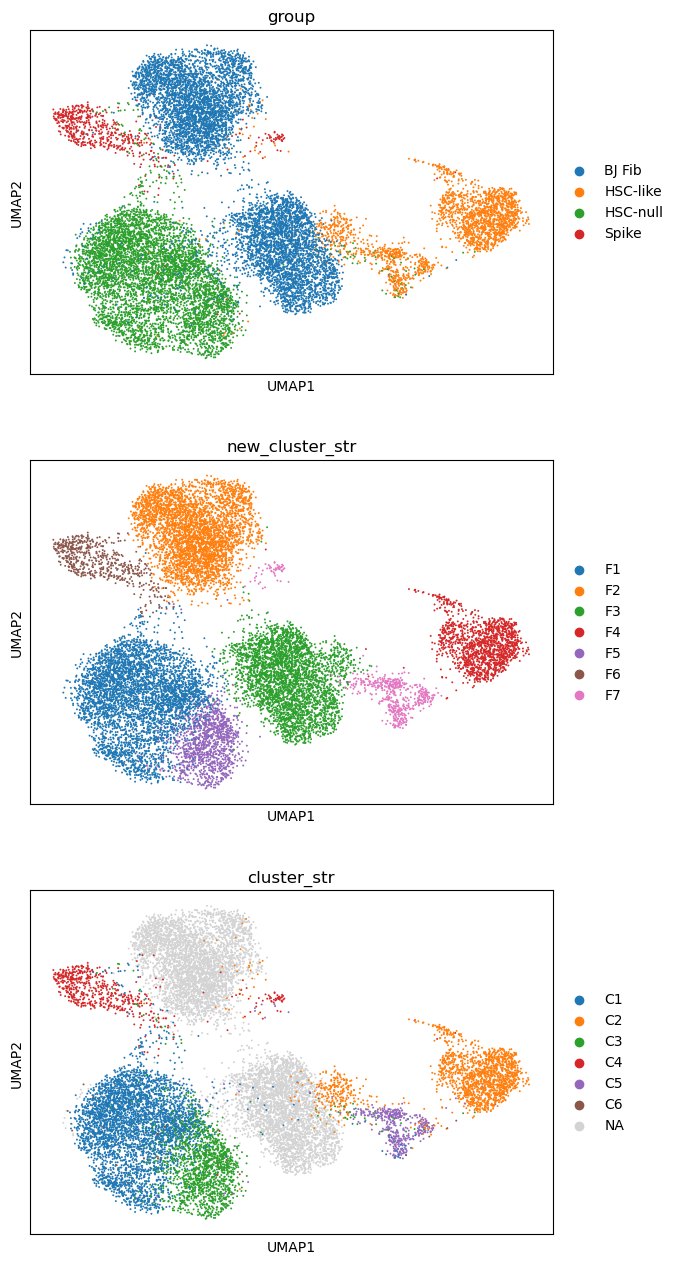

In [5]:
sc.pl.umap(
    adata,
    color=[
        'group',
        'new_cluster_str',
        'cluster_str',
    ],
    ncols=1,
)

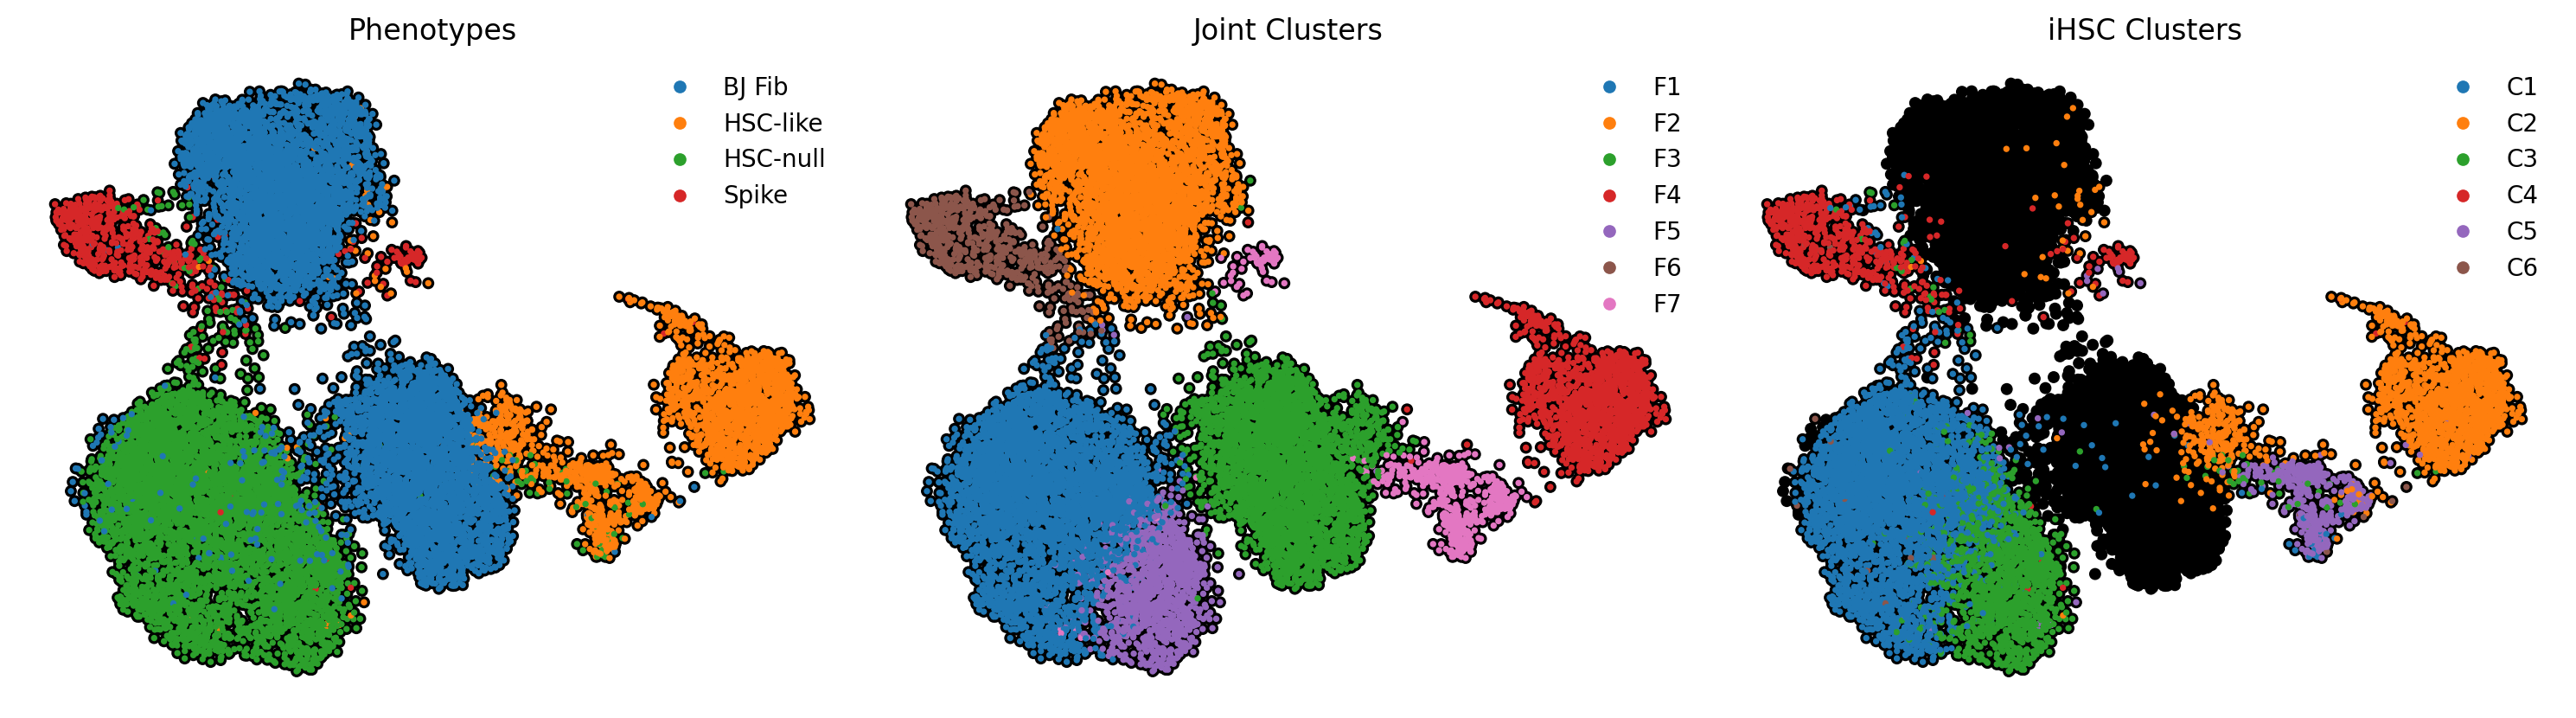

In [6]:
color = [
    'group',
    'new_cluster_str',
    'cluster_str',
]

titles = [
    'Phenotypes',
    'Joint Clusters',
    'iHSC Clusters',
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 4.25

fig, axs= plt.subplots(1, 3)
axs = axs.ravel()


for i, c in enumerate(color):

    sns.scatterplot(
        adata.obs,
        x='UMAP 1',
        y='UMAP 2',
        s=25,
        c='k',
        ec='none',
        ax=axs[i],
    )

    sns.scatterplot(
        adata.obs,
        x='UMAP 1',
        y='UMAP 2',
        ec='none',
        s=7,
        hue=c,
        ax=axs[i],
    )

    axs[i].set_aspect('auto')
    axs[i].axis(False)
    axs[i].set_title(titles[i])

    sns.move_legend(
        axs[i],
        loc='best',
        title="",
        frameon=False,
        markerscale=2,
    )


plt.tight_layout()

# Expression Patterns

In [7]:
aggdata = sc.get.aggregate(
    adata,
    by='new_cluster_str',
    func='mean',
    layer='combat',
)

df = aggdata.to_df(layer='mean')
df = df.T
df.head()

,F1,F2,F3,F4,F5,F6,F7
A1BG,0.155390,0.159506,0.216960,0.195985,0.165781,0.114718,0.082884
A2M,0.003162,0.005374,0.003319,0.010171,0.000572,0.013530,0.004983
A2ML1,0.519405,1.152636,0.419517,0.852885,0.458738,1.180953,0.652891
A3GALT2,0.112676,0.121852,0.099758,0.085561,0.093677,0.155581,0.119029
A4GNT,0.002792,-0.013719,0.007334,0.000978,0.007484,0.002531,-0.001232


Text(0.5, 1.0, 'All Gene Correlation')

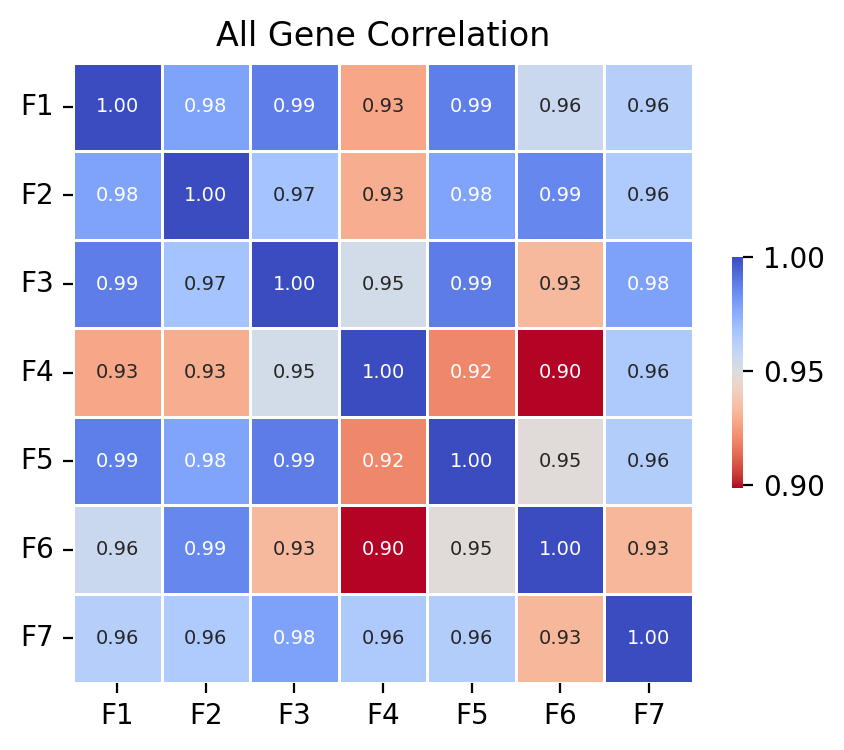

In [8]:
A = df.corr()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(
    A,
    lw=1,
    square=True,
    cmap='coolwarm_r',
    cbar_kws={'shrink' : 0.3},
    annot=True, 
    fmt=".2f", 
    annot_kws={"size": 7}  # Add annotations
)

plt.gca().tick_params(axis='y', rotation=0)
plt.title('All Gene Correlation')

# HVG

In [9]:
adata

AnnData object with n_obs × n_vars = 15475 × 13579
    obs: 'cluster_str', 'dataset', 'pred_phase', 'leiden', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'new_cluster', 'UMAP 1', 'UMAP 2', 'new_cluster_str', 'group'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cluster_str_colors', 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'pca', 'pred_phase_colors', 'umap', 'group_colors', 'new_cluster_str_colors'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    layers: 'combat', 'counts', 'log_norm', 'magic', 'n

Text(0.5, 1.0, 'HVG Correlation')

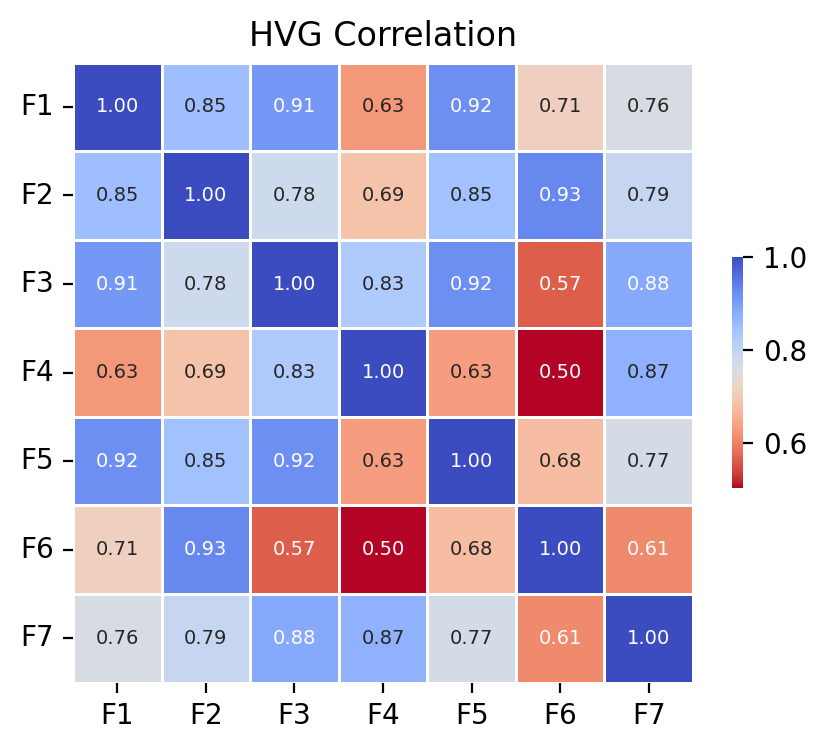

In [10]:
A = df[df.index.isin(adata.var[adata.var['highly_variable']].index)].corr()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(
    A,
    lw=1,
    square=True,
    cmap='coolwarm_r',
    cbar_kws={'shrink' : 0.3},
    annot=True, 
    fmt=".2f", 
    annot_kws={"size": 7}  # Add annotations
)

plt.gca().tick_params(axis='y', rotation=0)
plt.title('HVG Correlation')

# Load the Lab Data

In [11]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/lab_data/rajapakse_lab_data.h5ad"
bdata = sc.read_h5ad(fpath)
bdata = bdata[bdata.obs['dataset'] == 'chen_2015', :].copy()
bdata.layers['counts'] = bdata.X.copy()
bdata.obs['new_cluster_str'] = 'BJ'
bdata.obs['group'] = 'Bulk BJ'
sc.pp.normalize_total(bdata, target_sum=1e4)
sc.pp.log1p(bdata)
bdata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 18 × 19393
    obs: 'dataset', 'sample_id', 'timepoint', 'hour', 'n_counts', 'control', 'new_cluster_str', 'group'
    var: 'gene_id', 'token_id', 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_version', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_support_level', 'ensembl_id'
    uns: 'log1p'
    layers: 'counts'

In [12]:
# combine 
idata = an.concat([adata, bdata], label="batch", merge='same')
print(idata.obs['dataset'].value_counts())

# aggregate
aggdata = sc.get.aggregate(
    idata,
    by='new_cluster_str',
    func='mean',
    layer='counts',
)

df = aggdata.to_df(layer='mean')
df = df.T
target_sum = 1e4
df = df * (target_sum / df.sum()) # normalize
df = df.sort_values(by='BJ', ascending=False)

df.head()

dataset
iHSC         8346
scFib        7129
chen_2015      18
Name: count, dtype: int64


,BJ,F1,F2,F3,F4,F5,F6,F7
ACTG1,79.512816,0.040908,0.014461,0.021953,0.054563,0.029161,0.017081,0.030823
GAPDH,60.023411,0.101762,0.039767,0.053858,0.078158,0.076880,0.062631,0.079777
CD74,58.720422,0.037189,0.025507,0.037173,0.047190,0.037998,0.064529,0.034449
TUBB,52.185193,3.725965,4.286180,3.194866,2.813693,3.507325,4.331035,3.406849
ENO1,45.470238,0.000000,0.006226,0.004683,0.000000,0.000000,0.000000,0.000000


F6    3.322222
F4    3.677778
F7    3.922222
F1    3.944444
F2    4.333333
F5    4.355556
F3    4.444444
dtype: float64

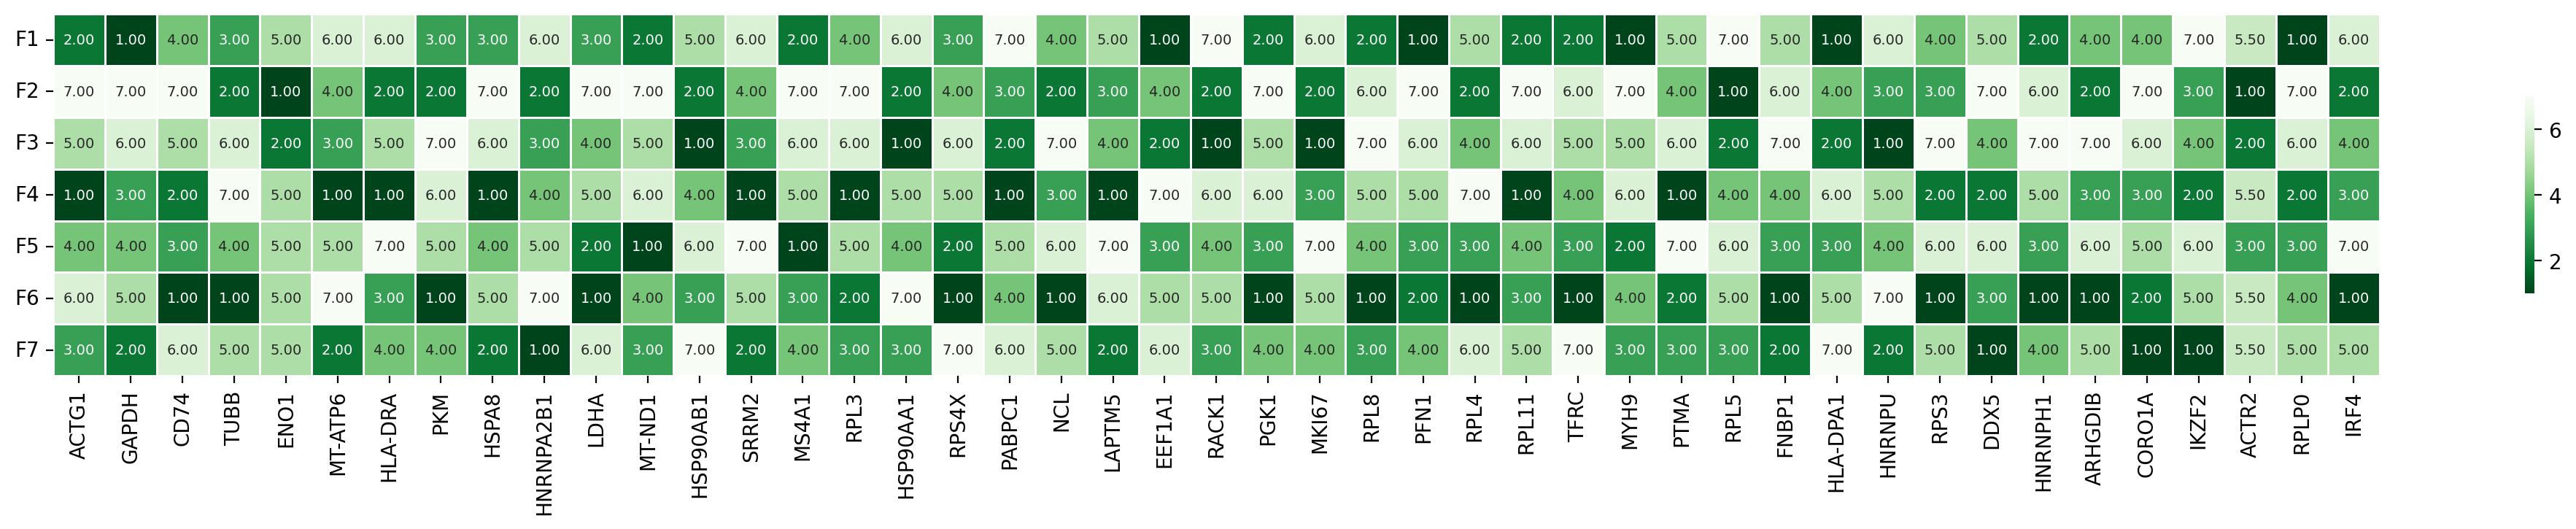

In [13]:
n_genes = 45
A = df.head(n_genes).drop(columns='BJ')
A = A.rank(axis=1, ascending=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (n_genes / 1.75 ), 5

sns.heatmap(
    data=A.T,
    square=True,
    lw=1,
    cmap='Greens_r',
    cbar_kws={'shrink' : 0.35},
    annot=True, 
    fmt=".2f", 
    annot_kws={"size": 7}  # Add annotations
)

plt.gca().tick_params(axis='y', rotation=0)

A.mean().sort_values()

232


F4    3.12
F6    3.68
F1    3.84
F3    4.08
F2    4.20
F7    4.44
F5    4.64
dtype: float64

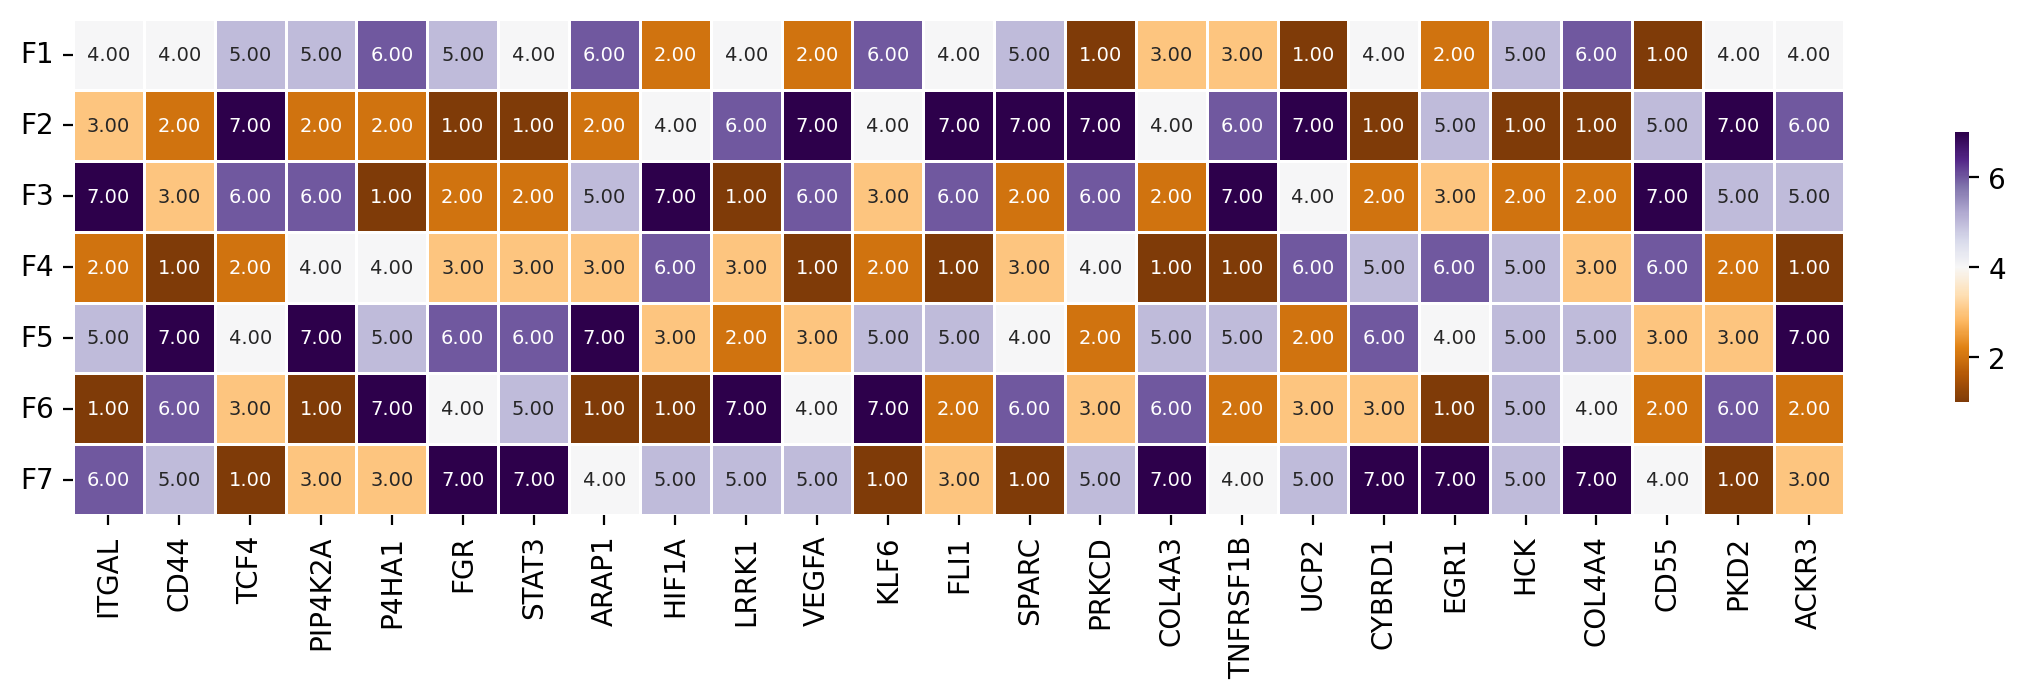

In [14]:
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
print(len(query_genes))

n_genes = 25
A = df[df.index.isin(query_genes)].head(n_genes).drop(columns='BJ')
A = A.rank(axis=1, ascending=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (n_genes / 1.75 ), 5

sns.heatmap(
    data=A.T,
    square=True,
    lw=1,
    cmap='PuOr',
    cbar_kws={'shrink' : 0.35},
    annot=True, 
    fmt=".2f", 
    annot_kws={"size": 7}  # Add annotations
)

plt.gca().tick_params(axis='y', rotation=0)

A.mean().sort_values()

# gene scoring

In [15]:
bjdf = bdata.to_df().mean().sort_values(ascending=False)
bjdf.name = 'bj_mean'
bjdf = bjdf.reset_index()
bjdf = bjdf[bjdf['gene_name'].isin(adata.var_names)]
bjdf = bjdf[~bjdf['gene_name'].str.startswith('MT')]
bjdf = bjdf[~bjdf['gene_name'].str.startswith('RP')]
bjdf = bjdf[bjdf['gene_name'].isin(adata.var_names)]
bjdf['rank'] = bjdf['bj_mean'].rank(ascending=False)
bjdf['is_marker'] = bjdf['gene_name'].isin(query_genes)

# Create bins based on quantiles
bins = 3
labels = ["low", "medium", "high"]
bjdf['bin'] = pd.qcut(bjdf['bj_mean'], q=bins, labels=labels, duplicates='drop')

print(f"{bjdf.shape=}")

bjdf.head(10)

bjdf.shape=(13420, 5)


,gene_name,bj_mean,rank,is_marker,bin
6,ACTG1,3.971786,1.0,False,high
9,GAPDH,3.700107,2.0,False,high
10,CD74,3.678945,3.0,False,high
12,TUBB,3.468012,4.0,False,high
13,ENO1,3.430439,5.0,False,high
16,HLA-DRA,3.394605,6.0,False,high
17,PKM,3.257222,7.0,False,high
21,HSPA8,3.125762,8.0,False,high
22,LDHA,3.112087,9.0,False,high
23,HNRNPA2B1,3.106777,10.0,False,high


computing score 'bj_low_score'
    finished: added
    'bj_low_score', score of gene set (adata.obs).
    1021 total control genes are used. (0:00:05)


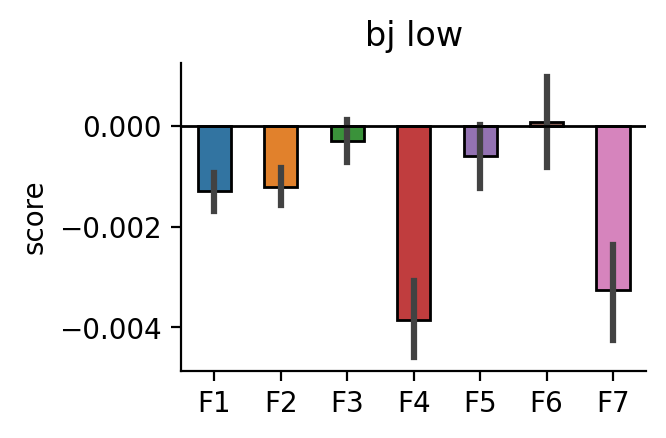

computing score 'bj_medium_score'
    finished: added
    'bj_medium_score', score of gene set (adata.obs).
    1020 total control genes are used. (0:00:05)


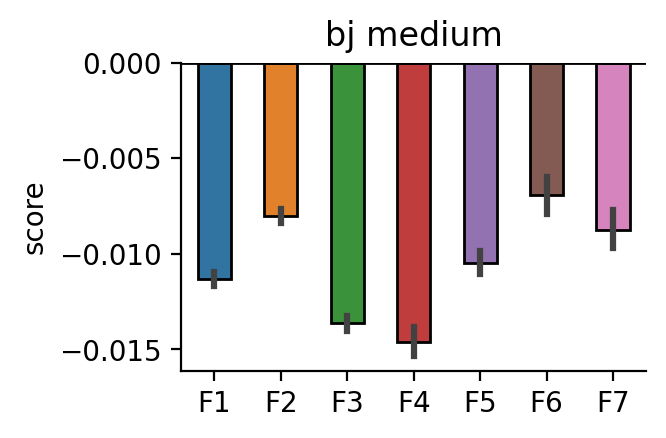

computing score 'bj_high_score'
    finished: added
    'bj_high_score', score of gene set (adata.obs).
    1031 total control genes are used. (0:00:05)


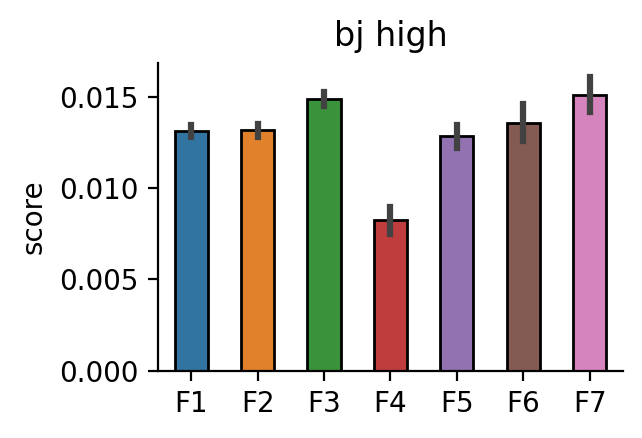

done


In [16]:
# score the bins
sample_size = 2000

adata.X = adata.layers['combat'].copy()

for bin, group in bjdf.groupby('bin'):
    gene_list = group['gene_name'].sample(sample_size).to_list()
    score_name = f"bj_{bin}_score"
    sc.tl.score_genes(
        adata, 
        gene_list,
        score_name=score_name,
        use_raw=False,
    )

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 3, 2

    sns.barplot(
        data=adata.obs,
        x='new_cluster_str',
        y=score_name,
        hue='new_cluster_str',
        width=0.5,
        ec='k',
    )

    plt.axhline(y=0, c='k', lw=1,)
    plt.ylabel(f"score")
    plt.title(f"bj {bin}")
    plt.xlabel("")
    sns.despine()
    plt.show()

print('done')

# Differential Expression

In [17]:
sc.tl.rank_genes_groups(
    adata, 
    groupby="new_cluster_str",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    use_raw=False,
    layer='combat',
    key_added='DEG',
)

deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='DEG',
)

deg.head()

ranking genes
    finished: added to `.uns['DEG']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:46)


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,F1,IL4I1,78.772797,1.507905,0.0,0.0,1.0,1.0
1,F1,ZNF416,77.306641,1.821116,0.0,0.0,1.0,1.0
2,F1,ZFP82,73.211983,1.569351,0.0,0.0,1.0,1.0
3,F1,UBE2S,72.886253,1.584934,0.0,0.0,1.0,1.0
4,F1,LRG1,66.523178,1.447684,0.0,0.0,1.0,1.0


In [18]:
alpha = 0.01
logfoldchanges = 1.5
sig = deg.copy()
sig = deg[deg['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > logfoldchanges]
print(f"{sig.shape=}")
print(f"{sig['names'].nunique()=}")
deg_genes = list(sig['names'].unique())
sig.head()

sig.shape=(2818, 8)
sig['names'].nunique()=1970


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,F1,IL4I1,78.772797,1.507905,0.0,0.0,1.0,1.0
1,F1,ZNF416,77.306641,1.821116,0.0,0.0,1.0,1.0
2,F1,ZFP82,73.211983,1.569351,0.0,0.0,1.0,1.0
3,F1,UBE2S,72.886253,1.584934,0.0,0.0,1.0,1.0
144,F1,SUSD3,57.682331,1.526664,0.0,0.0,1.0,1.0


In [19]:
aggdata = sc.get.aggregate(
    adata,
    by='new_cluster_str',
    func='mean',
    layer='combat',
)

df = aggdata.to_df(layer='mean')
df = df.T
df = df[df.index.isin(deg_genes)]
df.head()

,F1,F2,F3,F4,F5,F6,F7
A2M,0.003162,0.005374,0.003319,0.010171,0.000572,0.013530,0.004983
A2ML1,0.519405,1.152636,0.419517,0.852885,0.458738,1.180953,0.652891
AAK1,0.020155,0.099429,0.007764,0.032659,0.017543,0.251726,0.026953
AAMDC,0.006197,-0.024984,0.020744,-0.003339,0.014194,0.007651,0.002755
ABCB10,0.004638,0.011484,0.002249,0.005122,0.003376,0.024243,0.002631


Text(0.5, 1.0, 'DEG Correlation')

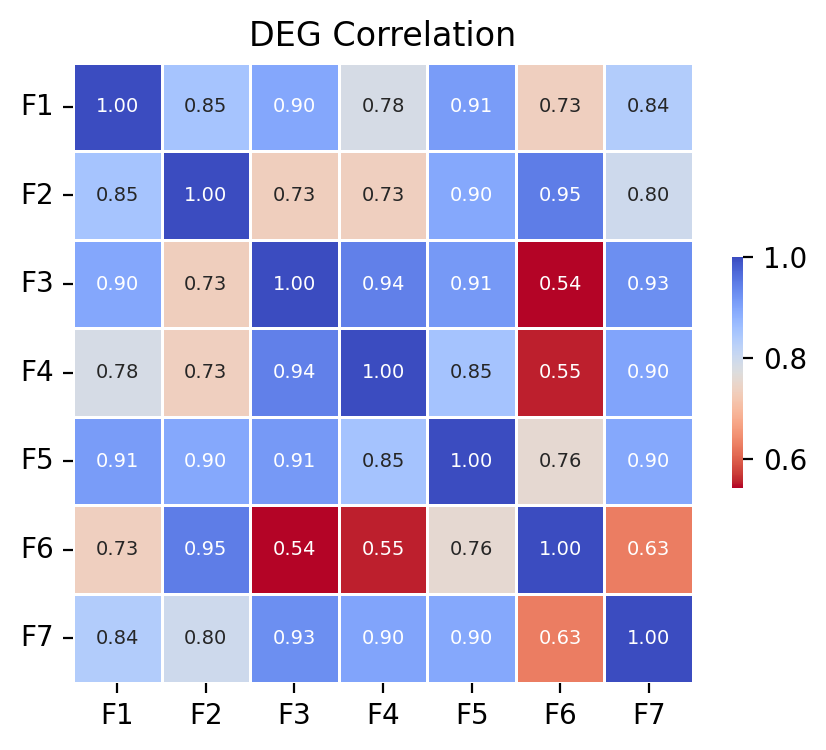

In [20]:
A = df.corr()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(
    A,
    lw=1,
    square=True,
    cmap='coolwarm_r',
    cbar_kws={'shrink' : 0.3},
    annot=True, 
    fmt=".2f", 
    annot_kws={"size": 7}  # Add annotations
)

plt.gca().tick_params(axis='y', rotation=0)
plt.title('DEG Correlation')

Text(0.5, 1.0, 'DEG Correlation')

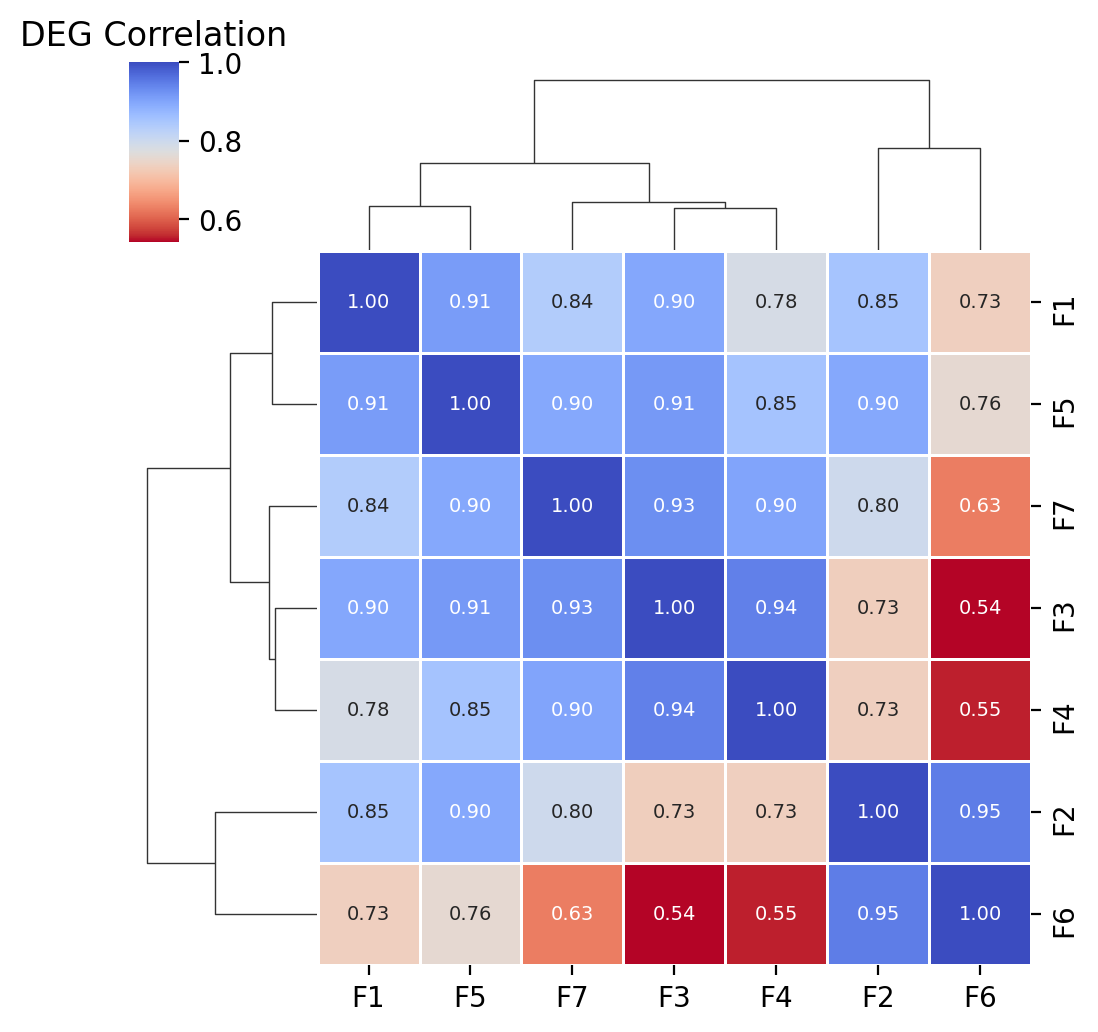

In [21]:
A = df.corr()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.clustermap(
    A,
    lw=1,
    square=True,
    cmap='coolwarm_r',
    figsize=(5, 5),
    cbar_kws={'shrink' : 0.3},
    annot=True, 
    fmt=".2f", 
    annot_kws={"size": 7} 
)

plt.gca().tick_params(axis='y', rotation=0)
plt.title('DEG Correlation')

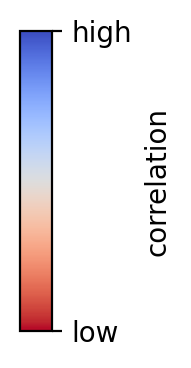

In [27]:
plt2.make_colorbar(cmap='coolwarm_r', title='correlation', tick_labels=['low', 'high'])

In [22]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
break

# Correlation over highly expressed

In [ ]:
aggdata = sc.get.aggregate(
    adata,
    by='new_cluster_str',
    func='mean',
    layer='combat',
)

df = aggdata.to_df(layer='mean')
df = df.T

df = pd.merge(
    df, 
    bjdf[['gene_name', 'bj_mean', 'bin']],
    how='left', 
    left_index=True, 
    right_on='gene_name',
)

df = df[df['bj_mean'].notna()]

df = df.set_index('gene_name')


for bin, group in df.groupby('bin'):
    group = group.drop(columns='bin')
    A = group.corr()

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 5, 5
    sns.heatmap(
        A,
        lw=1,
        square=True,
        cmap='coolwarm_r',
        cbar_kws={'shrink' : 0.3},
        annot=True, 
        fmt=".2f", 
        annot_kws={"size": 7}  # Add annotations
    )

    plt.gca().tick_params(axis='y', rotation=0)
    plt.title(f"bj {bin}")
    plt.show()



In [ ]:
gene_list = [
    'TUBB',
    'ITGAL',
    'PIP4K2A',
    'FGR',
    'ARAP1',
    'VEGFA',
    'SPARC',
    'CD55',
]

pdf = df.copy()
pdf = pdf[pdf.index.isin(gene_list)]
pdf = pdf.reset_index(drop=False, names='gene_name')
pdf = pd.melt(
    pdf, 
    id_vars='gene_name',
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

sns.barplot(
    data=pdf,
    x='gene_name',
    y='value',
    hue='variable',
    ec='k',
    width=0.65
)

plt.ylabel("mean expression")
plt.xlabel("")
plt.gca().tick_params(axis='x', rotation=90)

sns.move_legend(
    plt.gca(),
    loc='center right',
    title="",
    frameon=False,
    bbox_to_anchor=(1.25, 0.5),
)


sns.despine()

In [ ]:
break

In [ ]:
gene_list = [
    'ANGPTL2',
    # 'ITGAL',
    # 'PIP4K2A',
    # 'FGR',
    # 'ARAP1',
    # 'VEGFA',
    # 'SPARC',
    # 'CD55',
]

exp_df = adata[:, gene_list].to_df(layer='combat')
obs = adata.obs.copy()

for g in gene_list:

    obs['color'] = exp_df[g].values
    obs = obs.sort_values(by='color')

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 3.5, 3
    
    sns.scatterplot(
        data=obs,
        x='UMAP 1',
        y='UMAP 2',
        c='k',
        ec='none',
        s=15,
    )

    sns.scatterplot(
        data=obs,
        x='UMAP 1',
        y='UMAP 2',
        hue='color',
        palette='viridis',
        ec='none',
        s=5,
        alpha=0.95,        
        legend=False,
    )
    
    plt.title(g)
    plt.gca().axis(False)
    plt.show()


    
    

In [ ]:
break

# Differential Expression

In [ ]:
sc.tl.rank_genes_groups(
    adata, 
    groupby="group",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    use_raw=False,
    layer='combat',
    key_added='group',
)

deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='group',
)

deg.head()

In [ ]:
alpha = 0.05
logfoldchanges = 0.0
pct_nz_group = 0.25
sig = deg.copy()
sig = deg[deg['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > logfoldchanges]
sig = sig[sig['pct_nz_group'] >= pct_nz_group]
sig.head()

for cluster, group in sig.groupby('group'):
    print(f"{cluster=}")
    group = group.sort_values(by='logfoldchanges', ascending=False)
    
    print(group[['group', 'names', 'logfoldchanges', 'pct_nz_group']].head(10))
    print()
    break

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2

sc.pl.umap(
    adata,
    color=group['names'].head(10),
)


# Cluster C4 and V5 tags

In [ ]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/v5_tagged/v5_result.table.csv"
df = pd.read_csv(fpath)

v5_cols = [x for x in df.columns if "V5" in x]
print(f"{df.shape=}")
df['cell_id'] = df['barcode'] + "_iHSC"
df['has_v5'] = df[v5_cols].sum(axis=1) > 0
df = df[df['has_v5']]
print(f"{df.shape=}")
df.head()

In [ ]:
mask = adata.obs.index.isin(df['cell_id'].values)
adata.obs[mask]['cluster_str'].value_counts().div(adata.obs['cluster_str'].value_counts())

# Quantify Expression

In [ ]:
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

# [x for x in features.columns if 'hemato' in x.lower()]

pathway = 'Hematopoietic Stem Cells'
# pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
print(len(query_genes))
query_genes[:10]

In [ ]:
aggdata = sc.get.aggregate(
    adata,
    by='new_cluster_str',
    func='mean',
    layer='log_norm',
)

df = aggdata.to_df(layer='mean')
df = df.T
df = df[df.index.isin(query_genes)]
df.head()

In [ ]:
A = df.corr()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(
    A,
    lw=1,
    square=True,
    cmap='coolwarm_r',
    cbar_kws={'shrink' : 0.3},
    annot=True, 
    fmt=".2f", 
    annot_kws={"size": 7}  # Add annotations
)

plt.gca().tick_params(axis='y', rotation=0)

In [ ]:
break